### Notebook to visualize degron-likeness of proteins with predicted regions
- Figure 5c,d,e??

In [3]:
import pandas as pd
import os
import numpy as np
# Matplotlib
import matplotlib.colors as clr
from matplotlib import gridspec
import matplotlib.pyplot as plt
import matplotlib.colorbar as clb
from matplotlib import patches
from matplotlib import collections  as mc
%matplotlib inline
import pickle


### paths

In [4]:
base="../" 

# degrons
path_output_profile_degrons = os.path.join(base,"data","profile_degrons.pickle")
path_output_peaks = os.path.join(base,"data","peaks_degrons.tsv")
path_output_denovo_degrons = os.path.join(base,"data","de_novo_degrons.tsv")
path_output_dataframe = os.path.join(base,"data","predicte_degrons_properties.tsv.gz")
# RPPA
dataset_rppa_irls = os.path.join(base,"data/rppa_matched_irls.tsv.gz")
path_output_missense_degrons_rppa = os.path.join(base,"data","missense_clean_type_rppa.tsv.gz")
path_output_indels_degrons_rppa = os.path.join(base,"data","indels_clean_type_rppa.tsv.gz")

# output 
output_path_plots = os.path.join(base,"plots","Figure4","profiles")

# others
sequences = os.path.join(base,"data","sequences_isoforms.tsv")
pfam = os.path.join(base,"external","PFAM_data.tsv")
path_ubi_sites = os.path.join(base,"data/ubiquitination_sites_human.tsv.gz")
output_path_antibodies = os.path.join(base,"data","antibodies_figure4.tsv")

# output ylims 

output_dict_ylims = os.path.join(base,"data","ylims.pickle")

### aux functions

In [5]:
def calculate_lenght(row):
    return len(list(row["Sequence"]))
def to_hex(a,b,c):
    return '#%02x%02x%02x' % (int(a*255), int(b*255), int(c*255))
def get_pallete():
    my_pallete = []
    maxv = np.nanmax(1) 
    minv = np.nanmin(-1)
    norm = mpl.colors.Normalize(vmin=minv,vmax=maxv)
    sm = plt.cm.ScalarMappable(cmap=plt.cm.RdBu_r, norm=norm)
    nanvalue = (maxv+minv) / 2
    cmap = plt.cm.RdBu
    for i in range(cmap.N):
        rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
        my_pallete.append(matplotlib.colors.rgb2hex(rgb))
    return my_pallete,sm
def get_indel_position(position):
    if "-" in position:
        return int(position.split("-")[0])
    else:
        return int(position)
def get_pallete_zscore():
    my_pallete = []
    maxv = np.nanmax(3) 
    minv = np.nanmin(0)
    norm = clr.Normalize(vmin=minv,vmax=maxv)
    sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=norm)
    nanvalue = (maxv+minv) / 2
    cmap = plt.cm.Reds
    for i in range(cmap.N):
        rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
        my_pallete.append(clr.rgb2hex(rgb))
    return my_pallete,sm

def get_indel_position(position):
    if "-" in position:
        return int(position.split("-")[0])
    else:
        return int(position)
def load_data():
    # Mutations
    df_diff_info_missense = pd.read_csv(path_output_missense_degrons_rppa,sep="\t")
    df_diff_info_missense=df_diff_info_missense[(df_diff_info_missense["CNA"]<=1)&(df_diff_info_missense["CNA"]>=-1)&(np.isfinite(df_diff_info_missense["Stability_Change"]))&(~df_diff_info_missense["Altered_E3_Ligases"])&(~((df_diff_info_missense["Disrupt_Epitope"])&(df_diff_info_missense["Stability_Change"]<0)))]
    # Indels
    df_diff_info_inframe_tcga = pd.read_csv(path_output_indels_degrons_rppa,sep="\t")
    df_diff_info_inframe_tcga=df_diff_info_inframe_tcga[(df_diff_info_inframe_tcga["CNA"]<=1)&(df_diff_info_inframe_tcga["CNA"]>=-1)&(np.isfinite(df_diff_info_inframe_tcga["Stability_Change"]))&(df_diff_info_inframe_tcga["Altered_E3_Ligases"])&(~((df_diff_info_inframe_tcga["Disrupt_Epitope"])&(df_diff_info_inframe_tcga["Stability_Change"]<0)))]
    # Degrons
    df_properties_degron_info = pd.read_csv(path_output_dataframe,sep="\t",compression="gzip")
    # Domains
    df_pfam = pd.read_csv(pfam,sep="\t",comment="#")
    df_pfam = df_pfam[df_pfam["TYPE"]=="Domain"][["Entry","E_START","E_END","PFAM_ID","DOMAIN_NAME"]].drop_duplicates()
    # Sequence and Lenght
    df_sequences = pd.read_csv(sequences,sep="\t")
    df_sequences["Lenght"] = df_sequences.apply(lambda row: calculate_lenght(row),axis=1)
    # Ubiquitination sites
    df_ubi_sites = pd.read_csv(path_ubi_sites,sep="\t",compression="gzip")
    # Peaks
    df_peaks = pd.read_csv(path_output_peaks,sep="\t")
    # Antibodies
    df_antibodies = pd.read_csv(output_path_antibodies,sep="\t")
    # Profile
    d_profile = pickle.load(open(path_output_profile_degrons,'rb'))
    return df_diff_info_missense,df_diff_info_inframe_tcga,df_properties_degron_info,df_pfam,df_sequences,df_ubi_sites,df_peaks,df_antibodies,d_profile
df_diff_info_missense,df_diff_info_inframe_tcga,df_properties_degron,df_pfam,df_sequences,df_ubi_sites,df_peaks,df_antibodies,d_profile = load_data()

In [6]:
def get_annotations(up):
    l_annoations = []
    entry = up.split("-")[0]
    # Domain anotations
    for index,row in df_pfam[df_pfam["Entry"]==entry].iterrows():
        l_annoations.append([row["E_START"],row["E_START"]+((row["E_END"] - row["E_START"]) // 2),row["E_END"],row["E_END"]-row["E_START"]+1,row["DOMAIN_NAME"],"#C0C0C0",4])
    # Degron anotations
    for index,row in df_properties_degron[(df_properties_degron["Entry_Isoform"]==up)&(df_properties_degron["Prob_DEGRON"]>=0.5)].iterrows():
        l_annoations.append([row["START"],5,row["END"],row["END"]-row["START"]+1,row["DEGRON"],"#d98cb3",4])
    df_annotations = pd.DataFrame(l_annoations,columns=["START","POS","END","SIZE","NAME","Color","Font"])
    # Lysines
    seq = df_sequences[df_sequences["Entry_Isoform"]==up]["Sequence"].values[0]
    pos_lys = [int(x.split("-")[0] [1:]) for x in df_ubi_sites[df_ubi_sites["ACC_ID"]==up.split("-")[0]]["MOD_RSD"].values]
    df_lys = [1 if  int(s) in pos_lys else  0 for s in range(1,len(seq)+1)]         
    return df_annotations,df_lys

def get_mutations(up):
    
    # Mutations with rppa
    df_mis = df_diff_info_missense[(df_diff_info_missense["Entry_Isoform"]==up)]
    # Indels with rppa
    df_frame=df_diff_info_inframe_tcga[df_diff_info_inframe_tcga["Hugo_Symbol"]==gene]
    df_mutations = pd.concat([df_mis,df_frame])
    # Aggreate
    muts_position = df_mutations.groupby(["Protein_position","Phenotype","Protein"],as_index=False).agg({"Stability_Change":np.nanmean,"Matchable_Sample_ID":"count"})
    average = df_mutations.groupby(["Protein_position","Phenotype"],as_index=False).agg({"Stability_Change":np.nanmean,"Matchable_Sample_ID":"count"})
    return muts_position,average

    
def get_size_lines(up):
    ranges = []
    for index,row in df_peaks[df_peaks["Entry_Isoform"]==up].iterrows():
        for i in range(int(row["START_PEAK"]),int(row["END_PEAK"])+1):
            ranges.append(i)
    lws = [1.0 if v in ranges  else 0.5  for v in range (1,len(degron_values)+1)]
    return lws

def get_muts_degron(degrons,muts_position):
    
    l = []
    r = []
    for index,row in degrons.iterrows():
        for i in range(row["START"],row["END"]+1):
            r.append(i)
    for index,row in muts_position.iterrows():
        if row["Protein_position"]  in r:
            l.append(True)
        else:
            l.append(False)
    muts_position["Is_Degron"] = l
    return muts_position

    

In [7]:
def represent_profile_denovo_degron_average(up,gene,d):
    
    fig,ax = plt.subplots(nrows=3,ncols=1)
    fig.set_size_inches(4, 1.5)
    gs = gridspec.GridSpec(3, 1,height_ratios=[5,2,1])
    gs.update(wspace=0.025, hspace=0.15)
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1],sharex=ax0)
    ax2 = plt.subplot(gs[2],sharex=ax0)
    #colors = ["black","#d98cb3"]

    # Plot the first scatter. Mutations in the element 
    #ax0.scatter(muts_position[muts_position["Is_Degron"]]["Protein_position"].values,muts_position[muts_position["Is_Degron"]]["Stability_Change"].values,color=muts_position[muts_position["Is_Degron"]]["Color"].values,s=5,alpha=0.9)
    # outside of degron
    ax0.scatter(muts_position[~muts_position["Is_Degron"]]["Protein_position"].values,muts_position[~muts_position["Is_Degron"]]["Stability_Change"].values,color="grey",s=5,alpha=0.6,linewidth=0.0)
    # within degron
    ax0.scatter(muts_position[muts_position["Is_Degron"]]["Protein_position"].values,muts_position[muts_position["Is_Degron"]]["Stability_Change"].values,color=muts_position[muts_position["Is_Degron"]]["Color"].values,s=7,alpha=0.9,edgecolor="black",linewidth=0.5)
    # Calculate the mean and variance
    mean = np.nanmean(muts_position["Stability_Change"].values)
    var= np.nanstd(muts_position["Stability_Change"].values)
    ax0.axhline(y=mean,xmin=0,xmax=len(degron_values)+1,color="red",lw=1)
    # Draw it 
    var_pos = patches.Rectangle([0,-var],len(degron_values)+1,var*2,color="#c9c3c348")
    # Calculate the ymin and ymax
    ymin = int(np.nanmin(muts_position["Stability_Change"].values))-1
    ymax = int(np.nanmax(muts_position["Stability_Change"].values))+1
    # Prepare plot of profile
    x=[i for i in range (1,len(degron_values)+1)]
    y=degron_values
    xy = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.hstack([xy[:-1], xy[1:]])
    lc = mc.LineCollection(segments, linewidths=lws,color='black')
    ax1.add_collection(lc)
    ax1.axhline(y=0.5,xmin=0,xmax=len(degron_values)+1,ls="--",lw=1,color="black")

    # Draw rectangles with annotations
    for index,row in df_annotations.iterrows():
        colors = ["#ccffcc","#ffcc99","#b3e6ff"]
        r = patches.FancyBboxPatch([row["START"],0.2],row["END"]-row["START"]+1,0.7,linewidth=0.0,edgecolor='black',facecolor=row["Color"],boxstyle="round,pad=0.1")
        ax2.text(0.5*(row["START"]+row["END"]), 0.5, row["NAME"],        horizontalalignment='center',        verticalalignment='center',        fontsize=4, color='black',        )
        ax2.add_patch(r)
    # Now for each de-novo degron plot the rectangle and lines to mark the boundaries
    for index,row in degrons_query.drop_duplicates().iterrows():
        start = row["START"]
        end = row["END"]
        r = patches.FancyBboxPatch([start,0.2],end-start+1,0.7,linewidth=0.0,edgecolor='black',facecolor="#d98cb3",boxstyle="round,pad=0.1")
        ax2.text(0.5*(start+end), 0.5, str(start)+"-"+str(end),        horizontalalignment='center',        verticalalignment='center',        fontsize=4, color='black',        )
        ax2.add_patch(r)
        ax0.axvline(x=start-1,ymin=ymin,ymax=ymax,color="black",ls="dotted",alpha=0.5,lw=1)
        ax0.axvline(x=end+1,ymin=ymin,ymax=ymax,color="black",ls="dotted",alpha=0.5,lw=1)
        ax1.axvline(x=start-1,ymin=0,ymax=1.,color="black",ls="dotted",alpha=0.5,lw=1)
        ax1.axvline(x=end+1,ymin=0,ymax=1.,color="black",ls="dotted",alpha=0.5,lw=1)

    
    # Annotate ubiquitinated lysines
    for i in range(len(df_lys)):
        if df_lys[i] == 1: 

            r = patches.FancyBboxPatch([i,0.2],2,0.7,linewidth=0.0,edgecolor='black',facecolor="#099999ff",boxstyle="round,pad=0.1")
            ax2.add_patch(r)
    
    # Customization of the axis
    
    ax0.spines["top"].set_visible(False)
    ax0.spines["right"].set_visible(False)
    ax0.spines["bottom"].set_visible(False)
    ax1.spines["top"].set_visible(False)
    ax1.spines["right"].set_visible(False)
    ax1.spines["bottom"].set_visible(False)
    ax2.axis('off')
    
    ax0.tick_params(axis='y', labelsize=4,pad=0.01,width=0.15,)
    ax0.set_xticks([])
    ax0.set_xlim(0,len(degron_values)+1)
    ax0.set_title(gene+" ("+muts_position["Protein"].unique()[0]+")",fontsize=6)
    ax0.set_ylabel("Stability Change",fontsize=4)
    ax0.set_yticks(np.arange(ymin,ymax+1,1))
    ax0.set_yticklabels(np.arange(ymin,ymax+1,1),fontsize=4)
    ax0.set_ylim(ymin,ymax)
    d[up] = (ymin,ymax)
    ax0.spines['left'].set_linewidth(0.15)
    
    ax1.tick_params(axis='y', labelsize=4,pad=0.01,width=0.15)
    ax1.set_xlim(0,len(degron_values)+1)
    ax1.set_xticks([])
    ax1.tick_params(axis = 'x', labelsize =6  , pad=0.05 ,width=0.0)
    ax1.set_ylabel("Degron Probability",fontsize=4)
    ax1.set_yticks([0,1])
    ax1.set_yticklabels([0,1],fontsize=4)
    ax1.set_ylim(0,1)
    ax1.spines['left'].set_linewidth(0.15)

    
    _=plt.setp(ax0.get_xticklabels(), visible=False)
    _=plt.setp(ax2.get_xticklabels(), visible=False)
    _=plt.setp(ax1.get_xticklabels(), visible=False)
    
    
    plt.savefig(output_path_plots+"/"+gene+'_needle_mean.pdf', dpi=800,bbox_inches="tight")
    return d
    

# Read information of degrons, ub sites and ptm sites

In [8]:
degrons = pd.read_csv(path_output_denovo_degrons,sep="\t")
ups = degrons["Entry_Isoform"].unique()

/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/ipykernel/__main__.py:23: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



P10398-1 ARAF
P15056-1 BRAF
P51587-1 BRCA2
Q03135-1 CAV1
P19022-1 CDH2
O14757-1 CHEK1
P00533-1 EGFR
P21860-1 ERBB3
O43524-1 FOXO3
P23771-2 GATA3
P28482-1 MAPK1
P11836-1 MS4A1
Q02297-6 NRG1
P27986-1 PIK3R1
P17252-1 PRKCA
P29353-6 SHC1
Q12888-2 TP53BP1


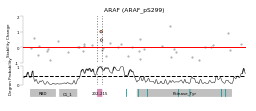

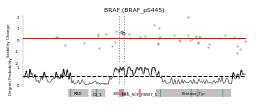

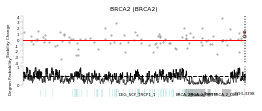

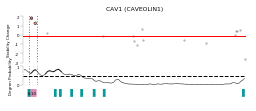

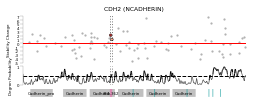

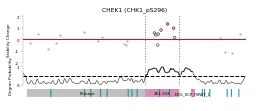

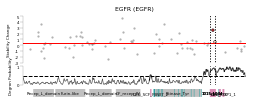

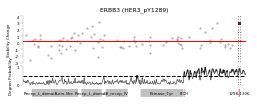

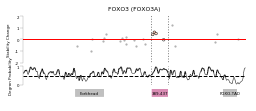

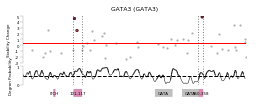

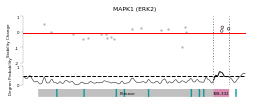

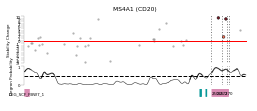

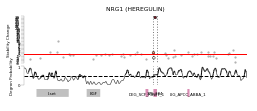

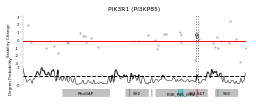

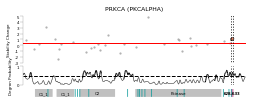

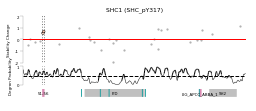

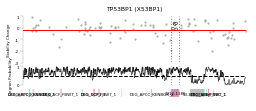

In [9]:
d ={}
for up in ups:
    
    gene = degrons[degrons["Entry_Isoform"]==up]["Hugo_Symbol"].values[0]
    #if os.path.exists('Figures/example_'+gene+'_needle_mean.pdf') and False:
    #    continue
    # Get annotations
    df_annotations,df_lys = get_annotations(up)
    # Get mutations
    muts_position,average=get_mutations(up)
    # Get profile degron
    degron_values=d_profile[(gene,up)]
    # Get lines 
    lws = get_size_lines(up)
    # Get degrons
    degrons_query = degrons[degrons["Entry_Isoform"]==up]
    # Get info mutations degron
    muts_position=get_muts_degron(degrons_query,muts_position)    
    muts_position = muts_position.merge(df_antibodies)
    # Prepare dataframe
    my_pallete,sm=get_pallete_zscore()
    muts_position["Color"] = muts_position.apply(lambda row: to_hex(*sm.to_rgba(row["Stability_Change"])[0:3]) if np.isfinite(row["Stability_Change"]) else "#B7B6B7",axis=1) # to_hex(*sm.to_rgba(nanvalue)[0:3])
    muts_position["Color"] = muts_position.apply(lambda row: to_hex(*sm.to_rgba(row["Stability_Change"])[0:3]) if np.isfinite(row["Stability_Change"]) else "#B7B6B7",axis=1) # to_hex(*sm.to_rgba(nanvalue)[0:3])
    muts_position["Size"] = 80 # to_hex(*sm.to_rgba(nanvalue)[0:3])
    d=represent_profile_denovo_degron_average(up,gene,d)
    print (up,gene)

pickle.dump(d,open(output_dict_ylims,'wb'))
    